# Task
The task is

>Generate four “populations” of data: normal, lightly skewed, medium-skewed, heavily-skewed. This is your dependent variable (DV). Using dependent variables (DV), generate independent variables (IV) that correlate with each DV at 0%, 10%, 30%, 50%, and 70% (so you’ll end up with 20 “populations” of IVs).
>
>Your simulations should do the following:
>1.	Create a linear regression model with one DV and 5 IVs (such that x1 correlates 10% with DV, x2 – 30%, etc.)
>2.	Generate 1000 (or more, if you wish) samples each of size 15, 30, 50, 100 for normal and skewed DVs
>3.	For each sample, run a linear regression and record R2, F-value, and p-values of each IV 
>4.	Analyze the results. Does non-normality have an impact on Type I and Type II error rates?

# Report

We comperehend the task as trying to find out how non-normality of data affects the false positive rate (Type I error) and the false negative rate (Type II error) for linear regression models. For that reason, the proposed computational simulation was run and analyzed. Below, all the code used for the simulation and output produced by it. 

An essence of our analysis and findings are provided here for easier access with references as required.

## Simulation Process

It was run as proposed in the task. It's essential to explain that

- We used the [skewed normal distribution](https://en.wikipedia.org/wiki/Skew_normal_distribution) (with the parameter $\alpha$) to generate the population for each case, each of the size defined by the variable *all_data_size* (10000). The skewness for the cases was set with $\alpha$ as follows

    - $\alpha = 0$ for the normal distribution,
    - $\alpha = 1$ for the lighty skewed normal distribution,
    - $\alpha = 3$ for medium-skewed normal distribution,
    - $\alpha = 100$ for heavily-skewed normal distribution.

- The skewness parameter $\gamma$ for all DV's was calculated and shown on the graph with PDF/KDE for DV's.
- For each DV I generate the other five IV's at the required levels of correlation by using the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) with the control afterwards.

- Each case's population was sampled with four different sample sizes (defined by *sample_sizes* = (15, 30, 50, 100)) 10000 times (defined by *samples_no*).

Check the [Simulation](#Simulation) chapter for details.

## Analysis

For each linear regression we estimated 

- distribution of $R^2$, $F$-statistic, $p$-value per each IV.
- calculated the number of Type I errors and Type II errors for reasoning about $F$-statistic (thus, considering all variables at once) as well as for $t$-statistic per each IV's (thus, considering the IV invididually).

Our reasoning is

1. We have got the whole population data, consequently, we know when $H_0$ is true or false for each IV.
2. Populaton-wise, $H_0$ is true for $x_1$, $H_0$ is false for $x_2, ..., x_5$. We know that from running OLS for the whole population for each case.
3. False positives (FP, type I errors) are cases when during the samping we rejected $H_0$ (at the significance level $\alpha=0.05$) whereas it's really true.
4. False negatives (FN, type II errors) are cases when during the samping we accepted $H_0$ (not found enough evidences against it at the significance level $\alpha=0.05$) whereas it's really false.
5. The error rate for FP, type I errors is $\frac{\#{FP}}{\#{samples}}$.
6. The error rate for FN, type II errors is $\frac{\#{FN}}{\#{samples}}$.

Check the [Analysis](#Analysis) chapter for details.

## Findings

Given the distributions used to draw data for the four cases of population, based on results from the sampling

- $R^2$ tends to its true value as the sample size increases approaching it from lower values, the skewness tends to distort the distribution of $R^2$ thus increasing the cost of finding true value of it. Check the [Distribution of R^2](## Distribution of R^2) section.
- Distribution of $F$-statistic also tends to be distorted (to have more variance) as the skewness increases thus making predictions less accurate.
- Distribution of $p$-value does not seem to affected by the skewness (judjing by graphs in [Distribution of p-values](## Distribution of p-values).

For Type I/II errors (see [Errors](## Errors))

- The Type I error rate (found only for $x_1$ because for all other IV's $H_0$ is true) stays at approximately the $\alpha$ significance level, it does not depend much on the sample size.
- The Type II error rate starts with pretty high values and rapidly decreases as the sample size increases.
- The Type II error drops as the association between DV and IV increases.
- The skewness does not seem to affect the error rates for estimating the significant of IV's.

In overall, the skewness for this *particular* simulation did not visually have significant effect on quality of linear regression. Might it be we need to choose another non-normal distribution for the populations?

# Global Settings

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Loading required libraries

In [2]:
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from sklearn.neighbors.kde import KernelDensity
import statsmodels.api as sm

plt.style.use('seaborn')

Setting some global and initial parameters

In [3]:
# the sample size (per case)
all_data_size = 10000

# parameters of distributions
#   skewed_0 - normal, 
#   skewed_{i} - skewed (the more skewed the greater the index is)
rvs_dist_params = {'xi': scipy.stats.skewnorm(loc = 0, scale = 3, a = 0),
                   'y0': scipy.stats.skewnorm(loc = 0, scale = 3, a = 0),
                   'y1': scipy.stats.skewnorm(loc = 0, scale = 3, a = 1),
                   'y2': scipy.stats.skewnorm(loc = 0, scale = 3, a = 3),
                   'y3': scipy.stats.skewnorm(loc = 0, scale = 3, a = 100)}

# rvs_dist_params = {'xi': scipy.stats.skewnorm(loc = 0, scale = 1, a = 0),
#                    'y0': scipy.stats.skewnorm(loc = 0, scale = 1, a = 0),
#                    'y1': scipy.stats.skewnorm(loc = 0, scale = 1, a = 2),
#                    'y2': scipy.stats.beta(a = 2, b = 5),
#                    'y3': scipy.stats.gamma(5)}


# number of cases
cases_no = 4

# the correlation matrix: y, x1, x2, ..., x5
corr_matrix = np.matrix([[1.0, 0.0, 0.1, 0.3, 0.5, 0.7],
                         [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                         [0.1, 0.0, 1.0, 0.0, 0.0, 0.0],
                         [0.3, 0.0, 0.0, 1.0, 0.0, 0.0],
                         [0.5, 0.0, 0.0, 0.0, 1.0, 0.0],
                         [0.7, 0.0, 0.0, 0.0, 0.0, 1.0]])

# number of iterations for sampling the whole data (population)
samples_no = 10000

# sizes of samples
sample_sizes = (15, 30, 50, 100)

alpha = 0.05

# Simulation

## Generating Data (Data Generation Process)

**The task**: 

>Generate four “populations” of data: normal, lightly skewed, medium-skewed, heavily-skewed. This is your dependent variable (DV). Using dependent variables (DV), generate independent variables (IV) that correlate with each DV at 0%, 10%, 30%, 50%, and 70% (so you’ll end up with 20 “populations” of IVs).

Drawing samples for both the dependent and independent variables

In [4]:
# generate samples with the Cholesky transformation
# this procedure generate all variables at once

# seed the random number generator
np.random.seed(42)

# draw random values out of those distributions
y = []
x = []
# x_ = []

for i in range(cases_no):
    
    # build set of random variables
    rv_y = rvs_dist_params['y%d' % i]
    #rv_x = rvs_dist_params['xi']
    rv_x = rv_y
    
    rvs = np.matrix([rv_y.rvs(size = all_data_size),
                     rv_x.rvs(size = all_data_size),
                     rv_x.rvs(size = all_data_size),
                     rv_x.rvs(size = all_data_size),
                     rv_x.rvs(size = all_data_size),
                     rv_x.rvs(size = all_data_size)])
    
    # the transformation to align RV's at the required level of correlation
    c = np.linalg.cholesky(corr_matrix)
    rvs = c * rvs
    
    y.append(rvs[0].A[0])
    x.append(rvs[1:].T.A)
    # x_.append(rvs[1:].A)
    
print('Y  shape: ' + str(np.shape(y)))
print('X  shape: ' + str(np.shape(x)))
# print('X_ shape: ' + str(np.shape(x_)))

Y  shape: (4, 10000)
X  shape: (4, 10000, 5)


Organizing data into DataFrame and listing the first two observations for each case.

In [5]:
df_sets = []

for i in range(cases_no):
    df_sets.append(pd.DataFrame({'y': y[i], 'x1': x[i][:,0], 'x2': x[i][:,1], 'x3': x[i][:,2], 'x4': x[i][:,3], 'x5': x[i][:,4]}))
    print(df_sets[i].head(2))

          y        x1        x2        x3        x4        x5
0 -2.035484 -5.941716 -0.496690  0.313998  1.294246 -1.744883
1  0.916498 -3.164957 -0.099711  3.471401  0.879367 -0.524129
          y        x1        x2        x3        x4        x5
0 -1.906817 -2.342660 -1.015170  2.232071  0.469857 -0.070674
1  1.440232  2.049626  2.863786  6.836453 -4.460578  2.127644
          y        x1        x2        x3        x4        x5
0  1.313038  1.109218  4.138433  3.549780  2.442632 -1.668399
1  4.634137 -0.333033  2.369795  4.654139  1.636472  2.971544
          y        x1        x2        x3        x4        x5
0  0.236050  1.185315  9.122635  3.364948 -0.757425 -0.809347
1  0.277431  1.149641  0.427687  5.107802  5.081117 -4.038190


Checking the correlation between $Y_i$ and $X_{ij}$ with np.corrcoef. 

In [6]:
for i in range(cases_no):
    
    print('#%d      ' % i, end = '')
    for j in range(5):
        print('X%d      ' % j, end = '')
    print('')    
    
    print('Y%d   ' % i, end = '')
    for j in range(5):
        print('%+0.2f   ' % (round(np.corrcoef(y[i], x[i][:, j])[0][1],2)), end = '')
    print('')
    print('')

#0      X0      X1      X2      X3      X4      
Y0   +0.00   +0.08   +0.30   +0.51   +0.69   

#1      X0      X1      X2      X3      X4      
Y1   -0.01   +0.10   +0.31   +0.50   +0.70   

#2      X0      X1      X2      X3      X4      
Y2   +0.01   +0.11   +0.31   +0.49   +0.70   

#3      X0      X1      X2      X3      X4      
Y3   -0.00   +0.11   +0.29   +0.50   +0.70   



Visualization of correlations between variables. Each heatmap is a separate case.

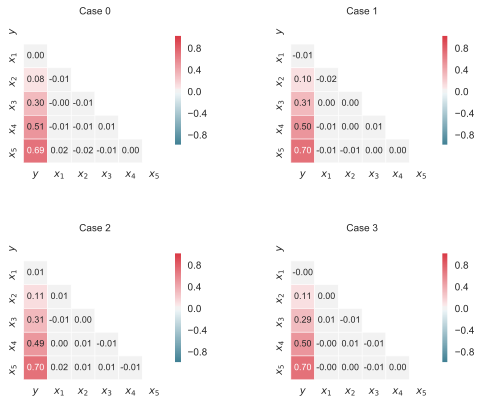

In [7]:
# plot correlation matrix
plt.style.use('seaborn-white')

fig, axs = plt.subplots(figsize=(8, 8), nrows = 2, ncols = 2)
fig.subplots_adjust(hspace=0, wspace=0.5)

axs_flatten = axs.flatten()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

for i in range(cases_no):
    
    corr = df_sets[i].corr()
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, 
                annot = True, annot_kws={"size": 9}, fmt = '.2f',
                cmap=cmap, vmin = -1, vmax= 1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax = axs_flatten[i])
    axs_flatten[i].set_title('Case %d' % i, size = 10)
    
    x_label_list = ['$%s$' % name if name == 'y' else '$%s_%s$' % (name[0], name[1]) for name in list(corr.columns)]
    axs_flatten[i].set_xticklabels(x_label_list)
    
    y_label_list = ['$%s$' % name if name == 'y' else '$%s_%s$' % (name[0], name[1]) for name in list(corr.index)]
    axs_flatten[i].set_yticklabels(y_label_list)

# fig.tight_layout()
plt.show()

plt.style.use('seaborn')

Drawing the distribution of dependent variables to visually control that there are that required skewness: 
* the *left* graph is the true distribution (we can draw it because we have exact distribution parameters),
* the *right* graph is the estimation of distribution with the kernel density estimation.

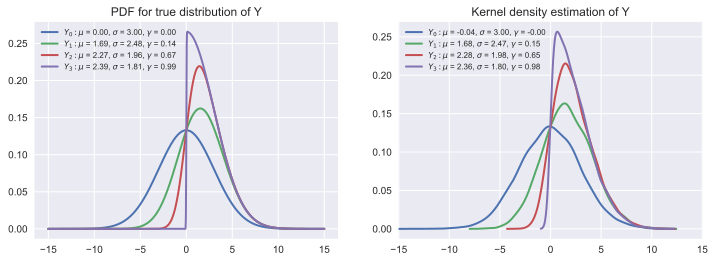

In [8]:
fig, axs = plt.subplots(figsize = (12, 4), ncols=2)

################################################################################
# draw ideal PDF of those DV's
################################################################################

xmin = -15
xmax =  15

plt.sca(axs[0])

x_range = np.linspace(xmin, xmax, 1000)

for i in range(cases_no):
    # define a random variables with given parameters
    rv = rvs_dist_params['y%d' % i]
    mean, var, skew = rv.stats(moments='mvs')
    std = math.sqrt(var)
    plt.plot(x_range, rv.pdf(x_range), lw = 2,
             label = r'$Y_%d: \mu$ = %1.2f, $\sigma$ = %1.2f, $\gamma$ = %1.2f' % 
             (i, mean, std, skew))

plt.title('PDF for true distribution of Y')
plt.legend(fontsize = 8)

################################################################################
# draw kernel distribuion estimation of the samples
################################################################################

plt.sca(axs[1])

for i in range(cases_no):
    
    mean = np.mean(y[i])
    std  = np.std(y[i])
    skew = scipy.stats.skew(y[i])
    
    kde = sm.nonparametric.KDEUnivariate(y[i])
    # kde.fit(kernel = 'epa', fft = False)
    kde.fit() # gaussian kernel with fft
    plt.plot(kde.support, kde.density, lw = 2, 
             label = r'$Y_%d: \mu$ = %1.2f, $\sigma$ = %1.2f, $\gamma$ = %1.2f' % 
             (i, mean, std, skew))

plt.xlim([xmin, xmax])    
    
plt.title('Kernel density estimation of Y')
plt.legend(fontsize = 8)

plt.show()

Now, there are four sets of samples, one set per each required combination of DV and IVs in the variables y and x. Let's do some simulation with it.

## Probing Data for Knowledge (Linear Regression of Samples)

**The task:**

>Your simulations should do the following:
>1.	Create a linear regression model with one DV and 5 IVs (such that x1 correlates 10% with DV, x2 – 30%, etc.)
>2.	Generate 1000 (or more, if you wish) samples each of size 15, 30, 50, 100 for normal and skewed DVs
>3.	For each sample, run a linear regression and record R2, F-value, and p-values of each IV 
>4.	Analyze the results. Does non-normality have an impact on Type I and Type II error rates?

We understand the task is that we need to run the simulation for 1-4 for each set of DV and IVs (we have four of them, let's call them cases). Variability among runs of the experiment is defined by randomness of samples and their size.

Creating linear regression models for the full set of observations for each case, the models are stored in the *models* list. The values from these models can probably considered as the most accurate estimations, let's say, the true values.

In [9]:
import statsmodels.api as sm

models = []
fits   = []

for i in range(cases_no):
    models.append(sm.OLS(y[i], sm.add_constant(x[i])))
    fits.append(models[i].fit())

Listing the results for each case

In [10]:
for i in range(cases_no):
    print('******************************************************************************')
    print('* Case #%d                                                                    *' % i)
    print('******************************************************************************')
    print(fits[i].summary())
    print('')
    print('')

******************************************************************************
* Case #0                                                                    *
******************************************************************************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                 1.018e+04
Date:                Tue, 26 Jun 2018   Prob (F-statistic):               0.00
Time:                        02:58:15   Log-Likelihood:                -16148.
No. Observations:               10000   AIC:                         3.231e+04
Df Residuals:                    9994   BIC:                         3.235e+04
Df Model:                           5                                         
Covariance Type:            nonrobust               

Creating major structures to work with those small but numerous samples (1000 per each case).

In [11]:
# samples in the following structure 
# {'case id': 
#     {'15':  <list of small samples>,
#      '30':  <list of small samples>,
#      '50':  <list of small samples>,
#      '100': <list of small samples>}}

samples = {}

# models for samples
samples_fits = {}

Just checking the logic of randomly selecting those small samples is correct.

In [12]:
# control

print('The first five observations')
print(y[0][:5])
print(x[0][:5,:])

print('')
indexes = [1, 2]
print('Choosing the observations %s' % indexes)
print(np.take(y[0], indexes))
print(np.take(x[0], indexes, axis = 0))

The first five observations
[-2.03548419  0.91649839 -1.79214318  0.33125414 -3.59153559]
[[-5.9417159  -0.49669006  0.31399785  1.29424644 -1.74488347]
 [-3.16495694 -0.09971081  3.47140104  0.87936713 -0.52412894]
 [ 1.76108522 -3.02027385 -4.75711515  1.44265755 -1.50923848]
 [ 0.44900673  4.6085686  -5.01522032 -1.61561991  2.10060265]
 [-3.07248698  1.69105868 -2.08376452 -8.70603837  4.4766898 ]]

Choosing the observations [1, 2]
[ 0.91649839 -1.79214318]
[[-3.16495694 -0.09971081  3.47140104  0.87936713 -0.52412894]
 [ 1.76108522 -3.02027385 -4.75711515  1.44265755 -1.50923848]]


In [13]:
np.random.seed(42)

for case in range(cases_no):
    samples[case] = {}
    for sample_size in sample_sizes:
        samples[case][sample_size] = [[None]] * samples_no
        for j in range(samples_no):
            # randomly generating indexes for those observations we'll take for the current sample
            indexes = np.random.randint(0, all_data_size - 1, sample_size)
            ys = np.take(y[case], indexes)
            xs = np.take(x[case], indexes, axis = 0)
            samples[case][sample_size][j] = [ys, xs]

Checking what a small sample looks like. It should be a list of two arrays: Y - the first one (1D), X - the second one (2D).

In [14]:
print('Y')
print()
print(samples[0][15][0][0])
print()
print('X1 - X5')
print()
print(samples[0][15][0][1])

Y

[ 3.6279734  -0.44890783  1.90356397  6.54352571 -4.71940807  2.90065025
 -2.45802478 -1.32097705 -0.32281031 -0.27416902  1.52092904  6.01922591
  0.1588184  -0.98277819 -0.58888085]

X1 - X5

[[-2.63957021e+00  7.18815712e-03  2.22012506e-01  7.58218581e+00
   8.99583644e-01]
 [ 1.85276771e-01  6.52091081e-01  6.10907039e+00  3.88867133e+00
  -3.79869921e+00]
 [ 1.03117403e+00 -4.51953199e+00 -3.31948935e+00  2.91984669e+00
   1.24093227e+00]
 [-1.01845514e+00 -3.07928832e+00 -1.12995697e+00  7.32439894e+00
   4.25424768e+00]
 [ 4.66503822e+00  4.29079471e+00 -6.82138478e-01 -3.89772533e+00
  -1.85808635e+00]
 [ 3.90772894e+00  9.91693669e-01 -9.22477448e-01  5.10670299e+00
   6.93596918e-01]
 [-6.13879629e+00 -7.14911724e+00  3.92199791e+00  2.53748826e-01
  -3.93205039e+00]
 [-2.69309134e+00  7.45406581e-02 -1.53121789e+00 -3.53510905e+00
   1.61315547e+00]
 [-4.03529585e+00  3.66386343e-01  4.58048133e+00 -2.10450947e+00
  -1.38926525e+00]
 [ 1.10778433e+00 -2.15793011e+00  1.5

Running the linear regression for those small samples. The results are gettings into the *samples_fits* variable. It has the same structure as *samples*.

In [15]:
for case in range(cases_no):
    samples_fits[case] = {}
    for sample_size in sample_sizes:
        samples_fits[case][sample_size] = []
        for sample in samples[case][sample_size]:
            ys = sample[0]
            xs = sample[1]
            m = sm.OLS(ys, sm.add_constant(xs)).fit()
            samples_fits[case][sample_size].append(m)

# Analysis

**The task:**

>4.	Analyze the results. Does non-normality have an impact on Type I and Type II error rates?

The null hypothesis for the case of linear regression is that there is no linear relationship between the dependent variable and the independent one(s). In the case of *multiple* linear regression we can consider this null hypothesis either *separately* for each independent variable (thus, testing if corresponding coefficient is equal to zero with the t-test) or *jointly* for all independent variables (tesing that all coefficiets are equal to zero with the F-test).

Now, to estimate the Type I and Type error rates (or the false positive rate and the false negative rate), it's required to know the truth to compare observated data and our reasoning about it in terms of the null hypothesis to classify the reasonings as true or erronomous (with corresponding error type).

The truth is the models for the populations of four cases. Estimations of the truth are the models for samples randomly drawn  from the populations.

## Extracting Statistics

Let's build the distribution of each linear regression models' statistics we are interested in. Capturing those statistics into *stats*.

In [16]:
stats = {}

# stats in the following structure 
# {<case id>: 
#     {<sample size>: 
#         {'rsquared': list,
#          'fvalue':   list,
#          'pvalues':  list}}}

for case in range(cases_no):
    stats[case] = {}
    for sample_size in sample_sizes:
        stats[case][sample_size] = {}
        stats[case][sample_size]['rsquared'] = [sample_model.rsquared for sample_model in samples_fits[case][sample_size]]
        stats[case][sample_size]['fvalue']   = [sample_model.fvalue   for sample_model in samples_fits[case][sample_size]]
        stats[case][sample_size]['f_pvalue'] = [sample_model.f_pvalue for sample_model in samples_fits[case][sample_size]]
        stats[case][sample_size]['pvalues']  = [sample_model.pvalues  for sample_model in samples_fits[case][sample_size]]

## Distribution of R^2

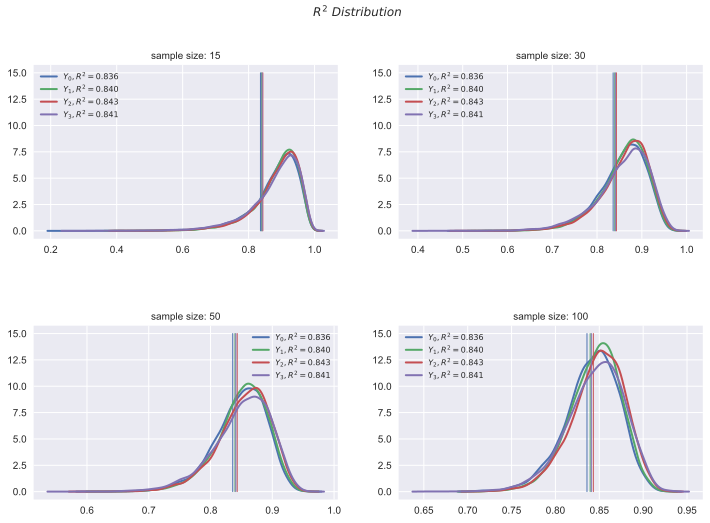

In [17]:
fig, axs = plt.subplots(figsize = (12, 8), nrows = 2, ncols=2)
fig.subplots_adjust(hspace=0.5, wspace=0.2)

axs_flatten = axs.flatten()

for i in range(len(sample_sizes)):
    sample_size = sample_sizes[i]
    plt.sca(axs_flatten[i])
    for case in range(cases_no):
        kde = sm.nonparametric.KDEUnivariate(stats[case][sample_size]['rsquared'])
        # kde.fit(kernel = 'epa', fft = False)
        kde.fit() # gaussian kernel with fft
        population_rsquared = fits[case].rsquared
        p = plt.plot(kde.support, kde.density, lw = 2, label='$Y_%d, R^2 = %.3f$' % (case, population_rsquared))
        plt.plot([population_rsquared, population_rsquared], [0, 15], 'k-', lw=1, color = p[0].get_color())
        plt.legend(fontsize = 8)
        plt.title('sample size: %d' % sample_size, size = 10)
        # drawing true R^2

plt.suptitle('$R^2\ Distribution$')        
        
plt.show()

## Distribution of F

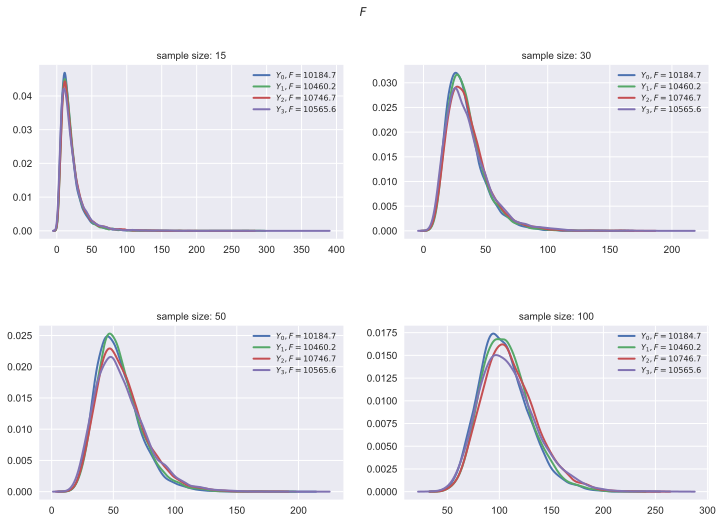

In [18]:
fig, axs = plt.subplots(figsize = (12, 8), nrows = 2, ncols=2)
fig.subplots_adjust(hspace=0.5, wspace=0.2)

axs_flatten = axs.flatten()

for i in range(len(sample_sizes)):
    sample_size = sample_sizes[i]
    plt.sca(axs_flatten[i])
    for case in range(cases_no):
        kde = sm.nonparametric.KDEUnivariate(stats[case][sample_size]['fvalue'])
        # kde.fit(kernel = 'epa', fft = False)
        kde.fit() # gaussian kernel with fft
        population_fvalue = fits[case].fvalue
        p = plt.plot(kde.support, kde.density, lw = 2, label='$Y_%d, F = %.1f$' % (case, population_fvalue))
        # plt.plot([population_fvalue, population_fvalue], [0, 1], 'k-', lw=1, color = p[0].get_color())
        plt.legend(fontsize = 8)
        plt.title('sample size: %d' % sample_size, size = 10)

plt.suptitle('$F$')        
        
plt.show()

## Distribution of p-values

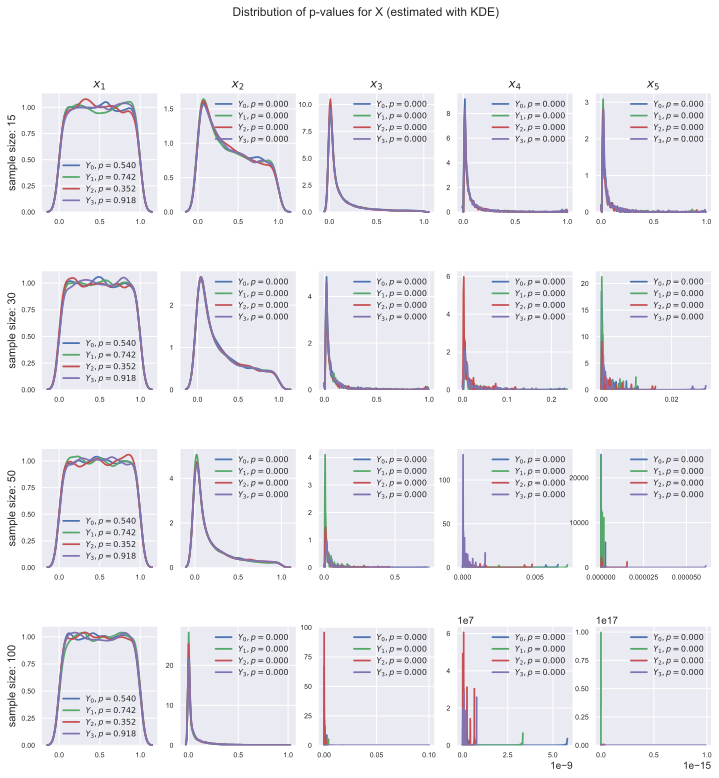

In [19]:
fig, axs = plt.subplots(figsize = (12, 12), nrows = 4, ncols=5)
fig.subplots_adjust(hspace=0.5, wspace=0.2)

axs_flatten = axs.flatten()

for i in range(len(sample_sizes)):
    sample_size = sample_sizes[i]    
    for j in range(5):
        plt.sca(axs[i][j])
        for case in range(cases_no):
            # getting p-values for the case, this sample size, this variable
            p = [pvalues[j+1] for pvalues in stats[case][sample_size]['pvalues']]
            
            #kde = sm.nonparametric.KDEUnivariate(p)
            #kde.fit() # gaussian kernel with fft
            #plt.plot(kde.support, kde.density, lw = 2, label='$Y_%d$' % case)
            
            population_pvalue = fits[case].pvalues[j+1]
            p = sns.distplot(p, hist = False, label='$Y_%d, p = %.3f$' % (case, population_pvalue))
            
            plt.legend(fontsize = 8)
            
            for tick in p.xaxis.get_major_ticks():
                tick.label.set_fontsize(7) 

            for tick in p.yaxis.get_major_ticks():
                tick.label.set_fontsize(7) 
                
for ax, j in zip(axs[0,:], range(5)):
    ax.set_title('$x_%d$' % (j + 1), size = 12)

for ax, sample_size in zip(axs[:,0], sample_sizes):
    ax.set_ylabel('sample size: %d' % sample_size, rotation=90)
                
#for ax in axs_flatten:
#    ax.label_outer()                

                
plt.suptitle('Distribution of p-values for X (estimated with KDE)')
        
plt.show()

## Errors

In [20]:
# the number of false positives and false negatives the following structure 
# {<case id>: 
#     {<sample size>: 
#         {'fp_coef_x'  : list of numbers of false positives (per coefficient),
#          'fn_coef_x'  : list of numbers of false positives (per coefficient),
#          'fp_coef_all': list of numbers of false positives (for all coefficients),
#          'fn_coef_all': list of numbers of false positives (for all coefficients)
#         }

falses = {}

# https://en.wikipedia.org/wiki/Type_I_and_type_II_errors
# In statistical hypothesis testing, a type I error is the rejection of a true null hypothesis 
# (also known as a "false positive" finding), while a type II error is failing to reject a 
# false null hypothesis (also known as a "false negative" finding).[1] More simply stated, 
# a type I error is to falsely infer the existence of something that is not there, 
# while a type II error is to falsely infer the absence of something that is.

for case in range(cases_no):

    falses[case] = {}

    # the state of H0's truth for all coefficients (based on the p-value for F-statistics)
    pop_coef_all_h0 = True if fits[case].f_pvalue > alpha else False
    
    for sample_size in sample_sizes:

        falses[case][sample_size] = {'fp_coef_all': 0, 'fn_coef_all': 0, 
                                     'fp_coef_x':  [[None]] * 6, 'fn_coef_x': [[None]] * 6}

        # getting the p-value for the case, this sample size
        f_pvalues = stats[case][sample_size]['f_pvalue']
        
        # getting the list of p-values for F-statistics for the case, this sample size
        # and calculate the false positives, the false negatives
        falses[case][sample_size]['fp_coef_all'] = sum(map(lambda x: 1 if     pop_coef_all_h0 and x <= alpha else 0, 
                                                           f_pvalues))
        falses[case][sample_size]['fn_coef_all'] = sum(map(lambda x: 1 if not pop_coef_all_h0 and x >  alpha else 0, 
                                                           f_pvalues))
        
        print('case: %d, sample size: %3d,   All:   FP: %4d,   FN: %4d' % 
              (case, sample_size, falses[case][sample_size]['fp_coef_all'], falses[case][sample_size]['fn_coef_all']))
        
        for j in range(1, 6):

            # the state of H0's truth for corresponding x's coefficient (based on the p-value for t-statistics)
            pop_coef_x_h0 = True if fits[case].pvalues[j] > alpha else False
            
            # getting the list of p-values for t-statistics for the case, this sample size, this variable
            t_pvalues = [pvalues[j] for pvalues in stats[case][sample_size]['pvalues']]
            
            # and calculate the false positives, the false negatives
            falses[case][sample_size]['fp_coef_x'][j] = sum(map(lambda x: 1 if     pop_coef_x_h0 and x <= alpha else 0, 
                                                            t_pvalues))
            falses[case][sample_size]['fn_coef_x'][j] = sum(map(lambda x: 1 if not pop_coef_x_h0 and x >  alpha else 0, 
                                                            t_pvalues))

            print('                             x%d :   FP: %4d,   FN: %4d' % 
                  (j,
                   falses[case][sample_size]['fp_coef_x'][j], 
                   falses[case][sample_size]['fn_coef_x'][j]))
        print('')

case: 0, sample size:  15,   All:   FP:    0,   FN:  146
                             x1 :   FP:  496,   FN:    0
                             x2 :   FP:    0,   FN: 8872
                             x3 :   FP:    0,   FN: 4656
                             x4 :   FP:    0,   FN: 1274
                             x5 :   FP:    0,   FN:  293

case: 0, sample size:  30,   All:   FP:    0,   FN:    0
                             x1 :   FP:  494,   FN:    0
                             x2 :   FP:    0,   FN: 7574
                             x3 :   FP:    0,   FN:  752
                             x4 :   FP:    0,   FN:   14
                             x5 :   FP:    0,   FN:    0

case: 0, sample size:  50,   All:   FP:    0,   FN:    0
                             x1 :   FP:  507,   FN:    0
                             x2 :   FP:    0,   FN: 6004
                             x3 :   FP:    0,   FN:   64
                             x4 :   FP:    0,   FN:    0
                             

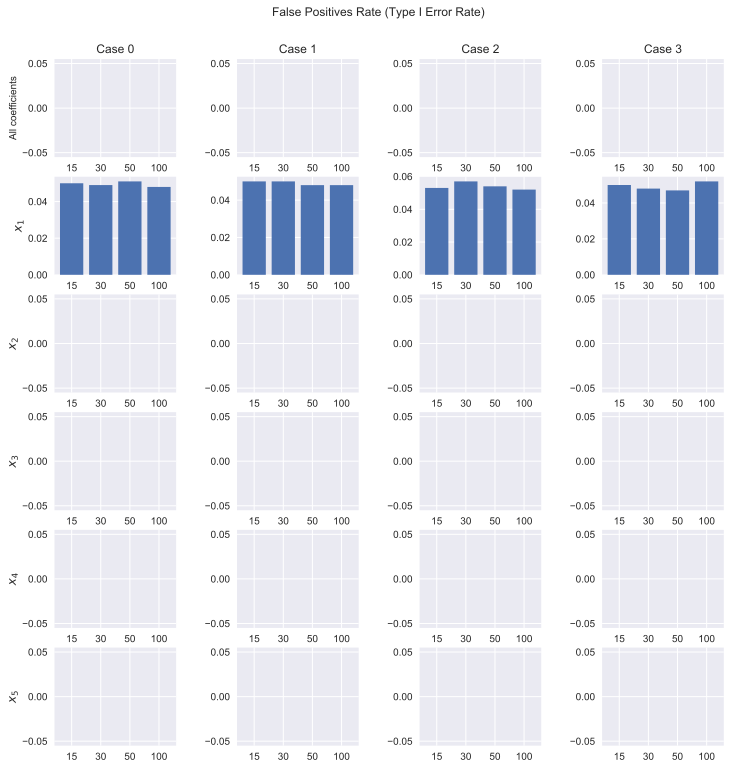

In [21]:
fig, axs = plt.subplots(figsize = (12, 12), nrows = 6, ncols=4)
fig.subplots_adjust(hspace=0.2, wspace=0.5, top = 0.92)

axs_flatten = axs.flatten()

for case in range(cases_no):
    
    plt.sca(axs[0][case])
    
    fp_coef_all = [round(v['fp_coef_all']/samples_no, 3) for k, v in falses[case].items()]
    
    #sns.barplot(x = 'sample_size', y = 'FP', data = pd.DataFrame({'sample_size': sample_sizes, 'FP': fp_coef_all}))
    plt.bar(x = [str(x) for x in sample_sizes], height = fp_coef_all)
      
    for var_no in range(1, 6):
        
        plt.sca(axs[var_no][case])

        fp_coef_x = [round(v['fp_coef_x'][var_no]/samples_no, 3) for k, v in falses[case].items()]
        
        plt.bar(x = [str(x) for x in sample_sizes], height = fp_coef_x)
        
for ax, case   in zip(axs[0,:], range(cases_no)):
    ax.set_title('Case %d' % case, size = 12)

for ax, var_no in zip(axs[:,0], range(6)):
    if var_no == 0:
        ax.set_ylabel('All coefficients', size = 10, rotation=90)
    else:
        ax.set_ylabel('$x_%d$' % var_no, size = 12, rotation=90)
        
#plt.tight_layout()

plt.suptitle('False Positives Rate (Type I Error Rate)')

plt.show()

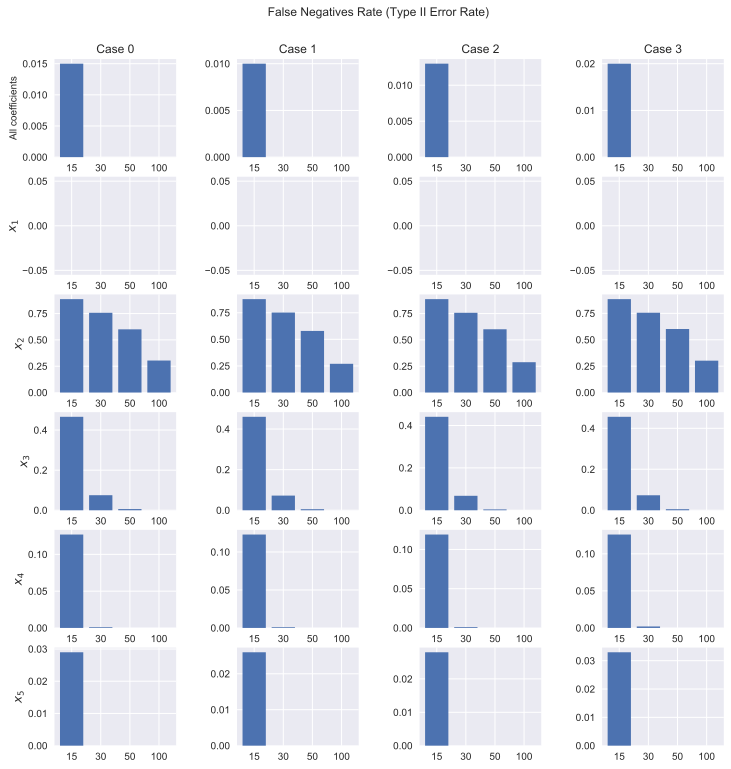

In [22]:
fig, axs = plt.subplots(figsize = (12, 12), nrows = 6, ncols=4)
fig.subplots_adjust(hspace=0.2, wspace=0.5, top = 0.92)

axs_flatten = axs.flatten()

for case in range(cases_no):
    
    plt.sca(axs[0][case])
    
    fp_coef_all = [round(v['fn_coef_all']/samples_no, 3) for k, v in falses[case].items()]
    
    #sns.barplot(x = 'sample_size', y = 'FP', data = pd.DataFrame({'sample_size': sample_sizes, 'FP': fp_coef_all}))
    plt.bar(x = [str(x) for x in sample_sizes], height = fp_coef_all)
      
    for var_no in range(1, 6):
        
        plt.sca(axs[var_no][case])

        fp_coef_x = [round(v['fn_coef_x'][var_no]/samples_no, 3) for k, v in falses[case].items()]
        
        plt.bar(x = [str(x) for x in sample_sizes], height = fp_coef_x)
        
for ax, case   in zip(axs[0,:], range(cases_no)):
    ax.set_title('Case %d' % case, size = 12)

for ax, var_no in zip(axs[:,0], range(6)):
    if var_no == 0:
        ax.set_ylabel('All coefficients', size = 10, rotation=90)
    else:
        ax.set_ylabel('$x_%d$' % var_no, size = 12, rotation=90)
        
#plt.tight_layout()

plt.suptitle('False Negatives Rate (Type II Error Rate)')

plt.show()

# References

General

1. http://www.statsmodels.org/dev/examples/notebooks/generated/kernel_density.html
2. https://en.wikipedia.org/wiki/Multicollinearity
3. https://en.wikipedia.org/wiki/Type_I_and_type_II_errors

The Cholesky transformation

1. https://www.quantumforest.com/2011/10/simulating-data-following-a-given-covariance-structure/
2. http://code.activestate.com/recipes/576512-generating-correlated-random-numbers/
3. https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Drawing_values_from_the_distribution
4. https://blogs.sas.com/content/iml/2012/02/08/use-the-cholesky-transformation-to-correlate-and-uncorrelate-variables.html
5. https://math.stackexchange.com/questions/163470/generating-correlated-random-numbers-why-does-cholesky-decomposition-work